In [1]:
# coding=utf-8
# Copyright 2021 DAF Trucks NV.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as: python3
"""Trains TFT based on a defined set of parameters.

Uses default parameters supplied from the configs file to train a TFT model from
scratch.

Usage:
python3 script_train_fixed_params {expt_name} {output_folder}

Command line args:
  expt_name: Name of dataset/experiment to train.
  output_folder: Root folder in which experiment is saved


"""

import argparse
import datetime as dte
import os

import data_formatters.base
import expt_settings.configs
import libs.hyperparam_opt
import libs.tft_model_2
import libs.utils as utils
import numpy as np
import pandas as pd
import tensorflow as tf
import data_formatters.daf_extended

ExperimentConfig = expt_settings.configs.ExperimentConfig
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
ModelClass = libs.tft_model_2.TemporalFusionTransformer
DafFormatter = data_formatters.daf_extended.DafExtendedFormatter()


def main(expt_name,
         model_folder,
         data_csv_path,
         data_formatter,
         use_testing_mode=False):
  """Trains tft based on defined model params.

  Args:
    expt_name: Name of experiment
    model_folder: Folder path where models are serialized
    data_csv_path: Path to csv file containing data
    data_formatter: Dataset-specific data fromatter (see
      expt_settings.dataformatter.GenericDataFormatter)
    use_testing_mode: Uses a smaller models and data sizes for testing purposes
      only -- switch to False to use original default settings
  """

  num_repeats = 1

  if not isinstance(data_formatter, data_formatters.base.GenericDataFormatter):
    raise ValueError(
        "Data formatters should inherit from" +
        "AbstractDataFormatter! Type={}".format(type(data_formatter)))

  # Tensorflow setup
  # default_keras_session = tf.keras.backend.get_session()

  # if use_gpu:
  #   tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=0)

  # else:
  #   tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

  print("*** Training from defined parameters for {} ***".format(expt_name))

  print("Loading & splitting data...")
  raw_data = pd.read_csv(data_csv_path, index_col=0)
  train, valid, test = data_formatter.split_data(raw_data)
  df = pd.concat([train,valid,test])
  train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
  )

  # Sets up default params
  fixed_params = data_formatter.get_experiment_params()
  params = data_formatter.get_default_model_params()
  params["model_folder"] = model_folder

  # Parameter overrides for testing only! Small sizes used to speed up script.
  if use_testing_mode:
    fixed_params["num_epochs"] = 1
    params["hidden_layer_size"] = 5
    train_samples, valid_samples = 100, 10

  # Sets up hyperparam manager
  print("*** Loading hyperparm manager ***")
  opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                     fixed_params, model_folder)

  # Training -- one iteration only
  print("*** Running calibration ***")
  print("Params Selected:")
  for k in params:
    print("{}: {}".format(k, params[k]))

  best_loss = np.Inf
  for _ in range(num_repeats):

    # tf.reset_default_graph()
    # with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:

      # tf.keras.backend.set_session(sess)

      params = opt_manager.get_next_parameters()
      model = ModelClass(params)

      if not model.training_data_cached():
        model.cache_batched_data(train, "train", num_samples=train_samples)
        model.cache_batched_data(valid, "valid", num_samples=valid_samples)

      # sess.run(tf.global_variables_initializer())
      model.fit()

      val_loss = model.evaluate()

      if val_loss < best_loss:
        opt_manager.update_score(params, val_loss, model)
        best_loss = val_loss

      # tf.keras.backend.set_session(default_keras_session)

  print("*** Running tests ***")
  # tf.reset_default_graph()
  # with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
    # tf.keras.backend.set_session(sess)
  best_params = opt_manager.get_best_params()
  model = ModelClass(best_params)

  model.load(opt_manager.hyperparam_folder)

  print("Computing best validation loss")
  val_loss = model.evaluate(valid)

  print("Computing test loss")
  output_map = model.predict(test, return_targets=True)
  targets = data_formatter.format_predictions(output_map["targets"])
  p50_forecast = data_formatter.format_predictions(output_map["p50"])
  p90_forecast = data_formatter.format_predictions(output_map["p90"])

  def extract_numerical_data(data):
    """Strips out forecast time and identifier columns."""
    return data[[
        col for col in data.columns
        if col not in {"forecast_time", "identifier"}
    ]]

  p50_loss = utils.numpy_normalised_quantile_loss(
      extract_numerical_data(targets), extract_numerical_data(p50_forecast),
      0.5)
  p90_loss = utils.numpy_normalised_quantile_loss(
      extract_numerical_data(targets), extract_numerical_data(p90_forecast),
      0.9)

    # tf.keras.backend.set_session(default_keras_session)

  print("Training completed @ {}".format(dte.datetime.now()))
  print("Best validation loss = {}".format(val_loss))
  print("Params:")

  for k in best_params:
    print(k, " = ", best_params[k])
  print()
  print("Normalised Quantile Loss for Test Data: P50={}, P90={}".format(
      p50_loss.mean(), p90_loss.mean()))

  return model, output_map, df


model, output_map, df = main(
      expt_name='daf',
      model_folder='tft_outputs/saved_models/daf/fixed',
      data_csv_path='tft_outputs/data/daf/tf_input_xf.csv',
      data_formatter=DafFormatter,
      use_testing_mode=False)  # Change to false to use original default params



2.5.0
*** Training from defined parameters for daf ***
Loading & splitting data...
Processed 0 out of 15 drivers in 6.974458694458008ms
Setting scalers with training data...
*** Loading hyperparm manager ***
*** Running calibration ***
Params Selected:
dropout_rate: 0.2
hidden_layer_size: 20
learning_rate: 0.001
minibatch_size: 64
max_gradient_norm: 1.0
num_heads: 4
stack_size: 1
model_folder: tft_outputs/saved_models/daf/fixed
Resetting temp folder
Cached data "train" updated
Cached data "valid" updated
*** Fitting TemporalFusionTransformer ***
Getting batched_data
Using cached training data
Using cached validation data
Using keras standard fit
Epoch 1/100
1628/1628 [==============================] - 253s 138ms/step - loss: 0.5786 - root_mean_squared_error: 1.1776 - mean_absolute_error: 0.9101 - val_loss: 0.5351 - val_root_mean_squared_error: 1.0408 - val_mean_absolute_error: 0.7878
Epoch 2/100
1628/1628 [==============================] - 228s 140ms/step - loss: 0.5134 - root_mean_squ

In [2]:
targets = list(output_map['targets']['t+0'].values)
p50 = list(output_map['p50']['t+0'].values)
p90 = list(output_map['p90']['t+0'].values)
p10 = list(output_map['p10']['t+0'].values)

In [3]:
target_unscaled = DafFormatter._target_scaler.inverse_transform(targets)
p50_unscaled = DafFormatter._target_scaler.inverse_transform(p50)
p90_unscaled = DafFormatter._target_scaler.inverse_transform(p90)
p10_unscaled = DafFormatter._target_scaler.inverse_transform(p10)

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('RMSE p10: {}'.format(mean_squared_error(targets, p10, squared=False)))
print('MAE p10: {}'.format(mean_absolute_error(targets, p10)))
print('RMSE p50: {}'.format(mean_squared_error(targets, p50, squared=False)))
print('MAE p50: {}'.format(mean_absolute_error(targets, p50)))
print('RMSE p90: {}'.format(mean_squared_error(targets, p90, squared=False)))
print('MAE p90: {}'.format(mean_absolute_error(targets, p90)))

RMSE p10: 0.998252373358879
MAE p10: 0.7300428891427864
RMSE p50: 0.7238838338188511
MAE p50: 0.48519650845735296
RMSE p90: 1.1233450886486207
MAE p90: 0.9062669891852417


In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('RMSE p10 unscaled: {}'.format(mean_squared_error(target_unscaled, p10_unscaled, squared=False)))
print('MAE p10 unscaled: {}'.format(mean_absolute_error(target_unscaled, p10_unscaled)))
print('RMSE p50 unscaled: {}'.format(mean_squared_error(target_unscaled, p50_unscaled, squared=False)))
print('MAE p50 unscaled: {}'.format(mean_absolute_error(target_unscaled, p50_unscaled)))
print('RMSE p90 unscaled: {}'.format(mean_squared_error(target_unscaled, p90_unscaled, squared=False)))
print('MAE p90 unscaled: {}'.format(mean_absolute_error(target_unscaled, p90_unscaled)))

RMSE p10 unscaled: 8.626810956176756
MAE p10 unscaled: 6.308967705426726
RMSE p50 unscaled: 6.255741731554525
MAE p50 unscaled: 4.193026433466984
RMSE p90 unscaled: 9.707851655706618
MAE p90 unscaled: 7.831881398322277


In [18]:
targets_d = list(output_map['targets'][output_map['targets']['identifier'] == 'XLRTEM4100G237751']['t+0'].values)
p50_d = list(output_map['p50'][output_map['p50']['identifier'] == 'XLRTEM4100G237751']['t+0'].values)
p90_d = list(output_map['p90'][output_map['p90']['identifier'] == 'XLRTEM4100G237751']['t+0'].values)
p10_d = list(output_map['p10'][output_map['p10']['identifier'] == 'XLRTEM4100G237751']['t+0'].values)
target_ud = DafFormatter._target_scaler.inverse_transform(targets_d)
p50_ud = DafFormatter._target_scaler.inverse_transform(p50_d)
p90_ud = DafFormatter._target_scaler.inverse_transform(p90_d)
p10_ud = DafFormatter._target_scaler.inverse_transform(p10_d)

In [19]:
print('RMSE p10 driver: {}'.format(mean_squared_error(targets_d, p10_d, squared=False)))
print('MAE p10 driver: {}'.format(mean_absolute_error(targets_d, p10_d)))
print('RMSE p50 driver: {}'.format(mean_squared_error(targets_d, p50_d, squared=False)))
print('MAE p50 driver: {}'.format(mean_absolute_error(targets_d, p50_d)))
print('RMSE p90 driver: {}'.format(mean_squared_error(targets_d, p90_d, squared=False)))
print('MAE p90 driver: {}'.format(mean_absolute_error(targets_d, p90_d)))

RMSE p10 driver: 1.3936385549646837
MAE p10 driver: 1.0336967069062952
RMSE p50 driver: 0.9836889842989822
MAE p50 driver: 0.6834506986070096
RMSE p90 driver: 1.4727927192191546
MAE p90 driver: 1.2113775483229856


In [20]:
print('RMSE p10 driver unscaled: {}'.format(mean_squared_error(target_ud, p10_ud, squared=False)))
print('MAE p10 driver unscaled: {}'.format(mean_absolute_error(target_ud, p10_ud)))
print('RMSE p50 driver unscaled: {}'.format(mean_squared_error(target_ud, p50_ud, squared=False)))
print('MAE p50 driver unscaled: {}'.format(mean_absolute_error(target_ud, p50_ud)))
print('RMSE p90 driver unscaled: {}'.format(mean_squared_error(target_ud, p90_ud, squared=False)))
print('MAE p90 driver unscaled: {}'.format(mean_absolute_error(target_ud, p90_ud)))

RMSE p10 driver unscaled: 12.043704213638831
MAE p10 driver unscaled: 8.933117781308733
RMSE p50 driver unscaled: 8.500955403102704
MAE p50 driver unscaled: 5.9063220150693905
RMSE p90 driver unscaled: 12.727747987234652
MAE p90 driver unscaled: 10.468620584587155


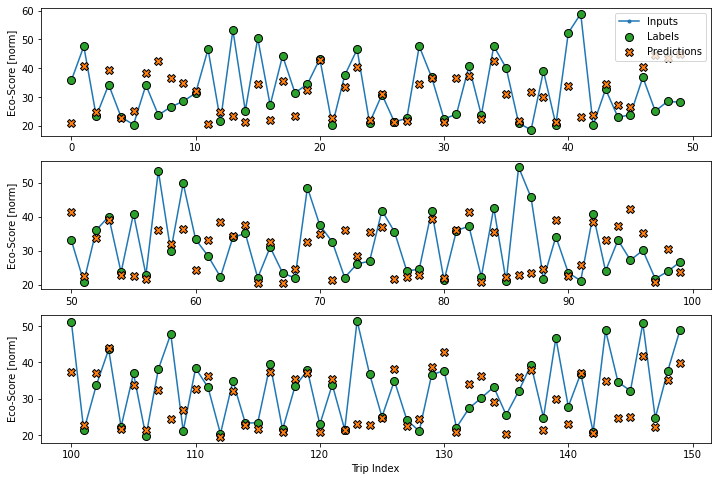

In [36]:
import matplotlib.pyplot as plt
def plot(targets, predictions, x_size=15,max_subplots=3,plot_col='Eco-Score'):
#   inputs, labels = self.example
  plt.figure(figsize=(12, 8))
#   plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(targets))
  cnt = 0
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [norm]')
    plt.plot(list(range(cnt,cnt+x_size)), targets[cnt:cnt+x_size],
             label='Inputs', marker='.', zorder=-10)

    plt.scatter(list(range(cnt,cnt+x_size)), targets[cnt:cnt+x_size],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    plt.scatter(list(range(cnt,cnt+x_size)), predictions[cnt:cnt+x_size],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
    if n == 0:
      plt.legend()
    cnt = cnt + x_size

  plt.xlabel('Trip Index')

plot(target_ud, p50_ud,x_size=50)

In [18]:
"""Trains TFT based on a defined set of parameters.

Uses default parameters supplied from the configs file to train a TFT model from
scratch.

Usage:
python3 script_train_fixed_params {expt_name} {output_folder}

Command line args:
  expt_name: Name of dataset/experiment to train.
  output_folder: Root folder in which experiment is saved


"""

ExperimentConfig = expt_settings.configs.ExperimentConfig
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
ModelClass = libs.tft_model_2.TemporalFusionTransformer
DafFormatter = data_formatters.daf_extended.DafExtendedFormatter()


def main_test(expt_name,
         model_folder,
         data_csv_path,
         data_formatter,
         drivers,
         use_testing_mode=False):
  """Trains tft based on defined model params.

  Args:
    expt_name: Name of experiment
    model_folder: Folder path where models are serialized
    data_csv_path: Path to csv file containing data
    data_formatter: Dataset-specific data fromatter (see
      expt_settings.dataformatter.GenericDataFormatter)
    use_testing_mode: Uses a smaller models and data sizes for testing purposes
      only -- switch to False to use original default settings
  """

  num_repeats = 1

  if not isinstance(data_formatter, data_formatters.base.GenericDataFormatter):
    raise ValueError(
        "Data formatters should inherit from" +
        "AbstractDataFormatter! Type={}".format(type(data_formatter)))

  # Tensorflow setup
  # default_keras_session = tf.keras.backend.get_session()

  # if use_gpu:
  #   tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=0)

  # else:
  #   tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

  print("*** Training from defined parameters for {} ***".format(expt_name))

  print("Loading & splitting data...")
  raw_data = pd.read_csv(data_csv_path, index_col=0)
  train, valid, test = data_formatter.split_data(raw_data, limit=27)
  train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
  )

  # Sets up default params
  fixed_params = data_formatter.get_experiment_params()
  params = data_formatter.get_default_model_params()
  params["model_folder"] = model_folder

  # Parameter overrides for testing only! Small sizes used to speed up script.
  if use_testing_mode:
    fixed_params["num_epochs"] = 1
    params["hidden_layer_size"] = 5
    train_samples, valid_samples = 100, 10

  # Sets up hyperparam manager
  print("*** Loading hyperparm manager ***")
  opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                     fixed_params, model_folder)

  # Training -- one iteration only
  print("*** Running calibration ***")
  print("Params Selected:")
  for k in params:
    print("{}: {}".format(k, params[k]))

  print("*** Running tests ***")
  # tf.reset_default_graph()
  # with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
    # tf.keras.backend.set_session(sess)
  best_params = opt_manager.get_next_parameters()
  model = ModelClass(best_params)

  model.load(opt_manager.hyperparam_folder)

  print("Computing best validation loss")
  val_loss = model.evaluate(valid)

  print("Computing test loss")
  output_map = model.predict(test, return_targets=True)
  targets = data_formatter.format_predictions(output_map["targets"])
  p50_forecast = data_formatter.format_predictions(output_map["p50"])
  p90_forecast = data_formatter.format_predictions(output_map["p90"])

  def extract_numerical_data(data):
    """Strips out forecast time and identifier columns."""
    return data[[
        col for col in data.columns
        if col not in {"forecast_time", "identifier"}
    ]]

  p50_loss = utils.numpy_normalised_quantile_loss(
      extract_numerical_data(targets), extract_numerical_data(p50_forecast),
      0.5)
  p90_loss = utils.numpy_normalised_quantile_loss(
      extract_numerical_data(targets), extract_numerical_data(p90_forecast),
      0.9)

    # tf.keras.backend.set_session(default_keras_session)

  print("Training completed @ {}".format(dte.datetime.now()))
  print("Best validation loss = {}".format(val_loss))
  print("Params:")

  for k in best_params:
    print(k, " = ", best_params[k])
  print()
  print("Normalised Quantile Loss for Test Data: P50={}, P90={}".format(
      p50_loss.mean(), p90_loss.mean()))

  return model, output_map


model, output_map = main_test(
      expt_name='daf',
      model_folder='tft_outputs/saved_models/daf/fixed',
      data_csv_path='tft_outputs/data/daf/tf_input_covid.csv',
      data_formatter=DafFormatter,
      drivers=df['DRIVERID'].unique(),
      use_testing_mode=False)  # Change to false to use original default params



*** Training from defined parameters for daf ***
Loading & splitting data...
Processed 0 out of 274 drivers in 5ms
Setting scalers with training data...
*** Loading hyperparm manager ***
*** Running calibration ***
Params Selected:
dropout_rate: 0.2
hidden_layer_size: 20
learning_rate: 0.001
minibatch_size: 64
max_gradient_norm: 1.0
num_heads: 4
stack_size: 1
model_folder: tft_outputs/saved_models/daf/fixed
*** Running tests ***
Resetting temp folder
Loading model from tft_outputs/saved_models/daf/fixed\TemporalFusionTransformer.ckpt


ValueError: Shapes (274, 20) and (27, 20) are incompatible